In [1]:
#!/usr/local/bin/python

import os, sys
import json
import numpy as np
import matplotlib.pyplot as plt
import chainer
from chainer import cuda
from matplotlib import animation
from optparse import OptionParser

from elecpy.util.cmap_bipolar import bipolar
import elecpy.elecpy as elp

from matplotlib import animation, rc
from IPython.display import HTML

import time
from scipy.interpolate import interp1d
%matplotlib inline



pyculib:1: ImportWarning: Numba version too old; expecting 0.33.0


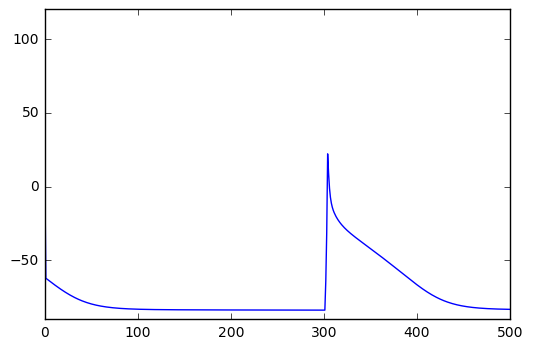

In [2]:
import h5py
input_file = "./test/courtmanche/400pacing_ilca*0.5_ikur*3.0_amp-20/out.h5"
with h5py.File(input_file,"r") as h5file:

    start=100
    dur=3000
    

    v=np.zeros(dur)
    for i in range(1,dur-1):
        a  = h5file["{0:0>5}/v".format(i+start)].value 
        #ti = np.arange(0,100.,1)
        #ax_v.plot(ti,v,'o')
        plt.xlim([0,500])
        plt.ylim([-90,120])
        v[i]=a

    time=np.arange(0,dur,1)
    plt.plot(time,v)
    plt.show()


In [3]:
data = v
data

array([  0.        , -62.08012106, -62.5649228 , ..., -83.296391  ,
       -83.29792897,   0.        ])

In [4]:
print('x',np.arange(len(data)))
print('v',np.asarray(data))

('x', array([   0,    1,    2, ..., 2997, 2998, 2999]))
('v', array([  0.        , -62.08012106, -62.5649228 , ..., -83.296391  ,
       -83.29792897,   0.        ]))


In [5]:
is_active = 1
APD_value = 0
maxtab = []
mintab = []
x = np.arange(len(data))
v = np.asarray(data)
mn, mx = np.Inf, -np.Inf
mnpos, mxpos = np.NaN, np.NaN
lookformax = True
for k in np.arange(len(v)):
    this = v[k]
    if this > mx:
        mx = this
        mxpos = x[k]
    if this < mn:
        mn = this
        mnpos = x[k]
    if lookformax:
        if this < mx-4:   ##mx-OO で検知する厳しさを設定
            maxtab.append((mxpos, mx))
            mn = this
            mnpos = x[k]
            lookformax = False
    else :
        if this > mn+4:
            mintab.append((mnpos, mn))
            mx = this
            mxpos = x[k]
            lookformax = True
maxtab = np.array(maxtab)
mintab = np.array(mintab)

if len(maxtab) < 4 or len(mintab) < 4:
      pass
else:
      if maxtab[0, 0] <= mintab[0,0]:
            
            APD_start = maxtab[1, 0]
    　else:
        　APD_start = maxtab[0, 0]
           
      if maxtab[-1, 0] >= mintab[-1, 0]:
          APD_end = mintab[-2, 0]
      else:
          APD_end = mintab[-1, 0]
      x_range = np.arange(0, int(APD_end)-int(APD_start), 1)
      max_y = np.mean(maxtab, axis=0)[1]
      min_y = np.mean(mintab, axis=0)[1]
      APD_50 = min_y + (max_y - min_y) * 0.5
      APD_90 = min_y + (max_y - min_y) * 0.1
      for k in range(x_range[0], x_range[-1]-1):
          start_time = filter(lambda x:x<=k, maxtab[:, 0])[-1]
          if is_active:
              if data[k] >= APD_90[k-x_range[0]] and data[k+1] < APD_90[k+1-x_range[0]]:
                  start_time = k
                  is_active = 0
          else:
              if data[k] <= APD_50[k-x_range[0]] and data[k+1] > APD_50[k+1-x_range[0]]:
                  is_active = 1
          if APD_value > 250:
              APD_value = 0
          data[k] = APD_value

IndentationError: unindent does not match any outer indentation level (<ipython-input-5-f924a0a81f6d>, line 39)

In [25]:
is_active = 1
maxtab = []
mintab = []
x = np.arange(len(data))
v = np.asarray(data)
mn, mx = np.Inf, -np.Inf
mnpos, mxpos = np.NaN, np.NaN
lookformax = True
for k in np.arange(len(v)):
    this = v[k]
    if this > mx:
        mx = this
        mxpos = x[k]
    if this < mn:
        mn = this
        mnpos = x[k]
    if lookformax:
        if this < mx-4:   ##mx-OO で検知する厳しさを設定
            maxtab.append((mxpos, mx))
            mn = this
            mnpos = x[k]
            lookformax = False
    else :
        if this > mn+4:
            mintab.append((mnpos, mn))
            mx = this
            mxpos = x[k]
            lookformax = True
maxtab = np.array(maxtab)
mintab = np.array(mintab)


In [18]:
if maxtab[0, 0] <= mintab[0,0]:
    
    APD_start = maxtab[1,0]
else:
    APD_start = maxtab[0, 0]        
if maxtab[-1, 0] >= mintab[-1, 0]:
    APD_end = mintab[-2, 0]
else:
    APD_end = mintab[-1, 0]

In [19]:
x_range = np.arange(0, int(APD_end)-int(APD_start), 1)
max_y = np.mean(maxtab, axis=0)[1]
min_y = np.mean(mintab, axis=0)[1]
APD_50 = min_y + (max_y - min_y) * 0.5
APD_90 = min_y + (max_y - min_y) * 0.1

In [34]:
for k in range(x_range[0], x_range[-1]-1):
    start_time = filter(lambda x:x<=k, maxtab[:, 0])[-1]
    if is_active:
        if data[k] >= APD_90 and data[k+1] < APD_90:
            APD_value = k - start_time
            is_active = 0
    else:
        if data[k] <= APD_50 and data[k+1] > APD_50:
            is_active = 1
    
        

In [35]:
print(APD_start)
print(APD_end)
print(APD_50)
print(APD_90)
print(APD_value)

304.0
2998.0
-32.1191957812
-73.2491173125
111.0


In [33]:
start_time = filter(lambda x:x<=1000, maxtab[:, 0])[-1]
start_time

704.0

In [16]:
APD_end

2998.0

In [7]:
maxtab

array([[    0.        ,     0.        ],
       [  304.        ,    22.16587808],
       [  704.        ,    22.12690169],
       [ 1104.        ,    22.05417493],
       [ 1504.        ,    22.03564152],
       [ 1904.        ,    22.00818998],
       [ 2304.        ,    21.99091132],
       [ 2704.        ,    21.96395155]])

In [8]:
print(np.mean(maxtab, axis=0)[1])

19.2932061328


In [69]:
maxtab[3,0]
maxtab[-1, 0]
x_range
print(max_convert) 
max_y.shape
min_y.shape
APD_50
maxtab[:,0]

array([  0.00000000e+00,   2.00000000e+00,   9.00000000e+00,
         1.01200000e+03,   2.01200000e+03,   3.01200000e+03,
         4.05900000e+03])

In [9]:
mintab

array([[  301.        ,   -83.68846019],
       [  701.        ,   -83.64374208],
       [ 1100.        ,   -83.60266164],
       [ 1500.        ,   -83.56282983],
       [ 1900.        ,   -83.52367081],
       [ 2300.        ,   -83.48539708],
       [ 2700.        ,   -83.44809097],
       [ 2998.        ,   -83.29792897]])

In [10]:
APD_value

NameError: name 'APD_value' is not defined

In [88]:
data.shape

(3000,)

In [91]:
max_y.shape

(2397,)

In [92]:
x_range[0]

203

In [97]:
a=np.load('/mnt/Share/ExperimentData/20190320-1/elec_pos.npy')

In [98]:
a


array([[ 81, 195],
       [106, 196],
       [124, 204],
       [162, 197],
       [189, 196],
       [ 71, 169],
       [106, 167],
       [133, 167],
       [164, 164],
       [190, 168],
       [ 78, 141],
       [107, 140],
       [135, 140],
       [160, 140],
       [187, 140],
       [ 76, 115],
       [107, 116],
       [132, 112],
       [159, 114],
       [186, 115],
       [ 77,  88],
       [ 96,  90],
       [131,  87],
       [161,  87],
       [181,  86]], dtype=int32)

In [99]:
elec_img = analysis.drawElectrodes(a, mapSize=(200, 200))
plt.imshow(elec_img)

NameError: name 'analysis' is not defined